# Training Transformer Recommender on INSPIRED Dataset

This notebook trains the Transformer-based movie recommender on the INSPIRED dataset.

## Environmental Setup

In [1]:
import os
import sys
from pathlib import Path

# Set working directory
os.chdir("..")

# Add project root to Python path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Check current directory
current_directory = os.getcwd()
print("Project Root:", project_root)
print("Current Working Directory:", current_directory)

Project Root: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS
Current Working Directory: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS


In [ ]:
!pip install -r requirements.txt

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW


import pandas as pd
import numpy as np
from tqdm import tqdm
import json

from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

# Import your transformer model
from scripts.rgcn_recommender import (
    RGCNRecommender,
    INSPIREDGraphBuilder,
    train_rgcn
)

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu


## DATA PREPARATION FOR TRAINING

### Load Dataset And Create Training Dataset

In [4]:
# Initialize data processor
data_processor = INSPIREDDataProcessor(dataset_dir="data")

# Load movie database
print("Loading movie database...")
movie_id_map, movie_name_map = data_processor.load_movie_database()

print(f"\nTotal movies in database: {len(movie_id_map)}")

# Load dialogs
print("\nLoading dialogs...")
train_dialogs = data_processor.load_dialogs(split="train", max_dialogs=None)
val_dialogs = data_processor.load_dialogs(split="dev", max_dialogs=None)

print(f"\nDataset sizes:")
print(f"Training: {len(train_dialogs)} dialogs")
print(f"Validation: {len(val_dialogs)} dialogs")

Loading movie database...
Loading 17869 movies from database...
After Filtering, loaded 17869 movies
Skipped: 0 missing titles + 0 'nan' titles
Total filtered: 0

Total movies in database: 16764

Loading dialogs...

Loading dialogs from train.tsv
Total turns in file: 28710
Unique dialogs: 801
Total movie mentions: 3966
Unique movies mentioned: 1725

Loading Summary
✓ Valid dialogs loaded: 759
✗ Dialogs skipped (no conversation): 0
✗ Dialogs skipped (no matching movies): 42
  Total movie mentions processed: 3966
  Movies matched to database: 2577
  Movies NOT in database: 1389
  Match rate: 65.0%


Loading dialogs from dev.tsv
Total turns in file: 3538
Unique dialogs: 99
Total movie mentions: 533
Unique movies mentioned: 328

Loading Summary
✓ Valid dialogs loaded: 96
✗ Dialogs skipped (no conversation): 0
✗ Dialogs skipped (no matching movies): 3
  Total movie mentions processed: 533
  Movies matched to database: 375
  Movies NOT in database: 158
  Match rate: 70.4%


Dataset sizes:
Tr

### PyTorch Dataset Class

In [5]:
class MovieRecommendationDataset(Dataset):
    """PyTorch Dataset for INSPIRED movie conversations"""
    
    def __init__(self, dialogs, num_movies, tokenizer, max_length=512):
        self.dialogs = dialogs
        self.num_movies = num_movies
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.dialogs)
    
    def __getitem__(self, idx):
        dialog = self.dialogs[idx]
        
        # Tokenize conversation
        encoding = self.tokenizer(
            dialog['conversation'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Create multi-hot label vector (1 for recommended movies, 0 for others)
        labels = torch.zeros(self.num_movies, dtype=torch.float)
        for movie_id in dialog['recommended_movies']:
            if movie_id < self.num_movies:
                labels[movie_id] = 1.0
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }

print("MovieRecommendationDataset class defined")

MovieRecommendationDataset class defined


### CREATE DATASETS AND DATALOADERS

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create datasets
train_dataset = MovieRecommendationDataset(
    train_dialogs, 
    len(movie_id_map), 
    tokenizer,
    max_length=512
)

val_dataset = MovieRecommendationDataset(
    val_dialogs, 
    len(movie_id_map), 
    tokenizer,
    max_length=512
)

# Create dataloaders
batch_size = 8  # Adjust based on your GPU memory

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to 0 for Windows
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"Created dataloaders:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {batch_size}")

Created dataloaders:
  Train batches: 95
  Val batches: 12
  Batch size: 8


### Initialize Model

In [7]:
model = TransformerRecommender(
    model_name="bert-base-uncased",
    num_movies=len(movie_id_map)
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")

Model initialized:
  Total parameters: 118,475,900
  Trainable parameters: 118,475,900
  Device: cpu


# TRAINING

### Training Configuration

In [8]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
weight_decay = 0.01

# Loss function (Binary Cross Entropy for multi-label)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Learning rate scheduler (optional)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

print("Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: CosineAnnealingLR")

Training Configuration:
  Epochs: 10
  Learning rate: 0.0001
  Weight decay: 0.01
  Optimizer: AdamW
  Scheduler: CosineAnnealingLR


### Training Functions

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / num_batches


@torch.no_grad()
def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    num_batches = 0
    hits_at_10 = 0
    total_samples = 0
    
    for batch in tqdm(val_loader, desc="Validating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        total_loss += loss.item()
        num_batches += 1
        
        # Calculate HIT@10
        _, top_10 = torch.topk(logits, k=10, dim=1)
        
        for i in range(labels.size(0)):
            ground_truth = (labels[i] == 1).nonzero(as_tuple=True)[0]
            predictions = top_10[i]
            
            if len(ground_truth) > 0:
                hit = any(pred in ground_truth for pred in predictions)
                hits_at_10 += int(hit)
                total_samples += 1
    
    avg_loss = total_loss / num_batches
    hit_at_10 = hits_at_10 / total_samples if total_samples > 0 else 0
    
    return avg_loss, hit_at_10

print("Training functions defined ✓")

Training functions defined ✓


### Training Loop

In [10]:


# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_hit_at_10': [],
    'learning_rates': []
}

best_val_loss = float('inf')
best_epoch = 0

# Create checkpoint directory
checkpoint_dir = Path("models/transformer_checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*60}")
print("STARTING TRAINING")
print(f"{'='*60}\n")

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 60)
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_hit_at_10 = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_hit_at_10'].append(val_hit_at_10)
    history['learning_rates'].append(current_lr)
    
    # Print epoch summary
    print(f"\nEpoch {epoch} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val HIT@10: {val_hit_at_10:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_hit_at_10': val_hit_at_10
        }
        
        torch.save(checkpoint, checkpoint_dir / 'best_model.pt')
        print(f"  ✓ New best model saved!")

print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}")
print(f"Best epoch: {best_epoch}")
print(f"Best val loss: {best_val_loss:.4f}")


STARTING TRAINING


Epoch 1/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]



Epoch 1 Summary:
  Train Loss: 0.1817
  Val Loss: 0.0030
  Val HIT@10: 0.2188
  Learning Rate: 0.000098
  ✓ New best model saved!

Epoch 2/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]



Epoch 2 Summary:
  Train Loss: 0.0023
  Val Loss: 0.0017
  Val HIT@10: 0.2812
  Learning Rate: 0.000090
  ✓ New best model saved!

Epoch 3/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.21s/it]



Epoch 3 Summary:
  Train Loss: 0.0015
  Val Loss: 0.0014
  Val HIT@10: 0.2917
  Learning Rate: 0.000079
  ✓ New best model saved!

Epoch 4/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.23s/it]



Epoch 4 Summary:
  Train Loss: 0.0013
  Val Loss: 0.0013
  Val HIT@10: 0.3229
  Learning Rate: 0.000065
  ✓ New best model saved!

Epoch 5/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.17s/it]



Epoch 5 Summary:
  Train Loss: 0.0012
  Val Loss: 0.0013
  Val HIT@10: 0.2917
  Learning Rate: 0.000050
  ✓ New best model saved!

Epoch 6/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.18s/it]



Epoch 6 Summary:
  Train Loss: 0.0012
  Val Loss: 0.0013
  Val HIT@10: 0.3125
  Learning Rate: 0.000035
  ✓ New best model saved!

Epoch 7/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:50<00:00,  4.21s/it]



Epoch 7 Summary:
  Train Loss: 0.0011
  Val Loss: 0.0013
  Val HIT@10: 0.3021
  Learning Rate: 0.000021
  ✓ New best model saved!

Epoch 8/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:51<00:00,  4.27s/it]



Epoch 8 Summary:
  Train Loss: 0.0011
  Val Loss: 0.0013
  Val HIT@10: 0.3125
  Learning Rate: 0.000010
  ✓ New best model saved!

Epoch 9/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]



Epoch 9 Summary:
  Train Loss: 0.0011
  Val Loss: 0.0013
  Val HIT@10: 0.3125
  Learning Rate: 0.000002

Epoch 10/10
------------------------------------------------------------


Validating: 100%|██████████| 12/12 [00:52<00:00,  4.34s/it]


Epoch 10 Summary:
  Train Loss: 0.0011
  Val Loss: 0.0013
  Val HIT@10: 0.3125
  Learning Rate: 0.000000

TRAINING COMPLETE
Best epoch: 8
Best val loss: 0.0013


### Validation

### Save Final Model

In [14]:
# Save final model
final_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}

torch.save(final_checkpoint, checkpoint_dir / 'final_model.pt')
print(f"Final model saved to: {checkpoint_dir / 'final_model.pt'}")

# Save training history
history_data = {
    'timestamp': datetime.now().isoformat(),
    'num_epochs': num_epochs,
    'best_epoch': best_epoch,
    'best_val_loss': best_val_loss,
    'history': history
}

with open(checkpoint_dir / 'training_history.json', 'w') as f:
    json.dump(history_data, f, indent=2)

print(f"Training history saved to: {checkpoint_dir / 'training_history.json'}")

Final model saved to: models\transformer_checkpoints\final_model.pt
Training history saved to: models\transformer_checkpoints\training_history.json


### VIZ TRAINING HISTORY

Training plot saved to: models\transformer_checkpoints\training_history.png


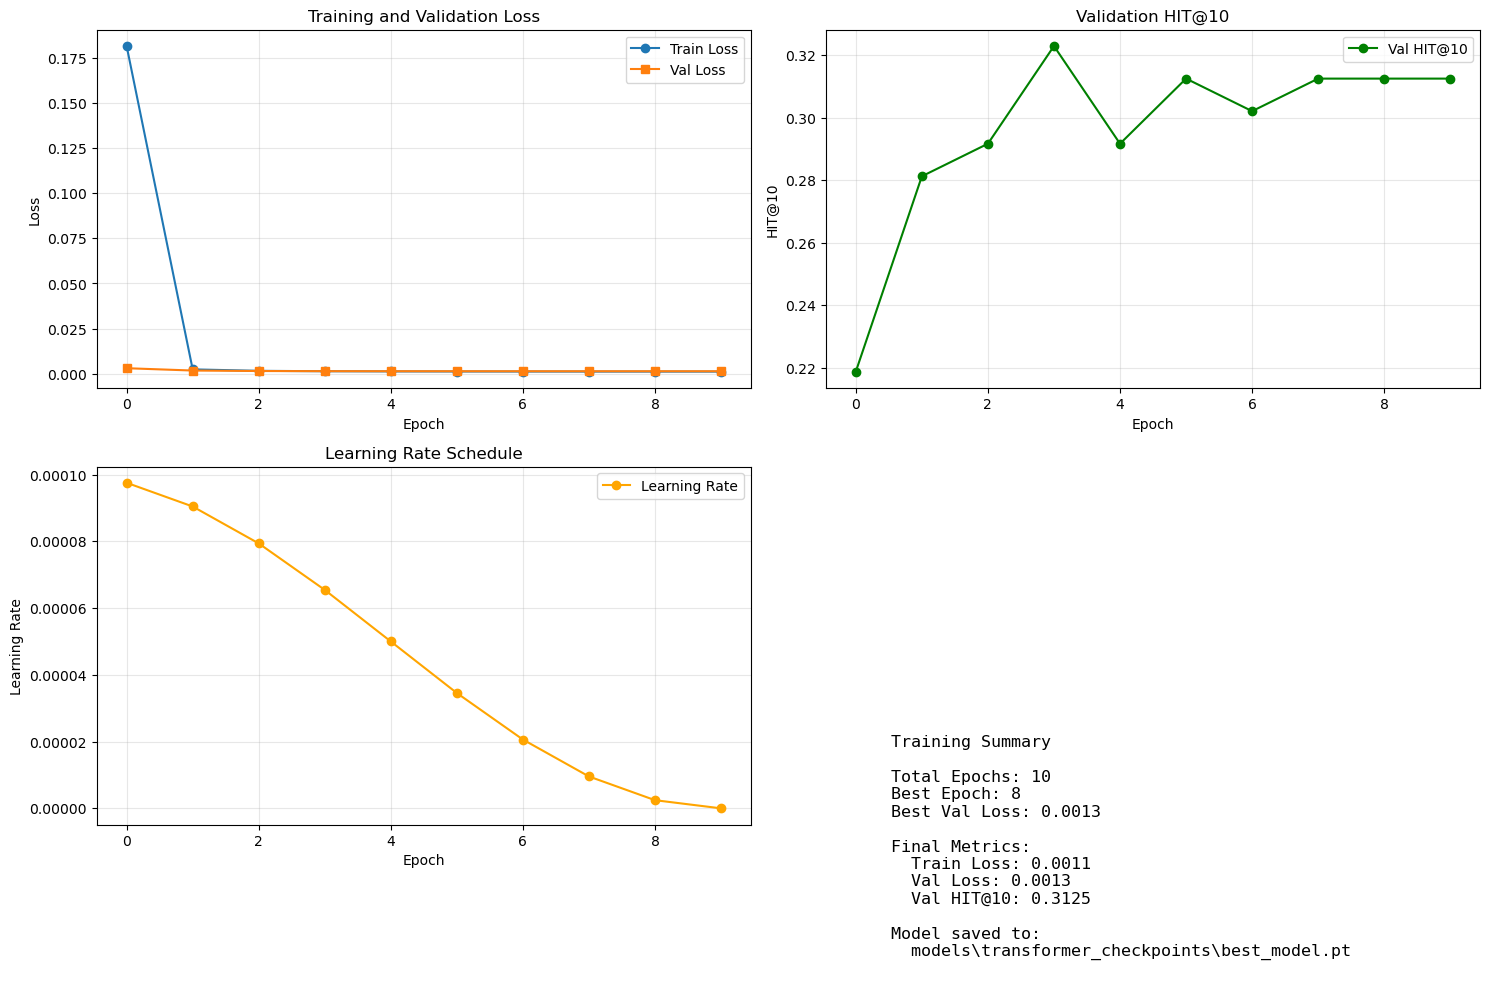

In [12]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: HIT@10
axes[0, 1].plot(history['val_hit_at_10'], label='Val HIT@10', color='green', marker='o')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('HIT@10')
axes[0, 1].set_title('Validation HIT@10')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate
axes[1, 0].plot(history['learning_rates'], label='Learning Rate', color='orange', marker='o')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Summary
axes[1, 1].axis('off')
summary_text = f"""
Training Summary

Total Epochs: {num_epochs}
Best Epoch: {best_epoch}
Best Val Loss: {best_val_loss:.4f}

Final Metrics:
  Train Loss: {history['train_loss'][-1]:.4f}
  Val Loss: {history['val_loss'][-1]:.4f}
  Val HIT@10: {history['val_hit_at_10'][-1]:.4f}

Model saved to:
  {checkpoint_dir / 'best_model.pt'}
"""
axes[1, 1].text(0.1, 0.3, summary_text, fontsize=12, family='monospace',
                verticalalignment='top')

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_history.png', dpi=150, bbox_inches='tight')
print(f"Training plot saved to: {checkpoint_dir / 'training_history.png'}")
plt.show()

## Test Trained Model

In [13]:

# Load best model
checkpoint = torch.load(checkpoint_dir / 'best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Best model loaded!")
print(f"Epoch: {checkpoint['epoch']}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}")
print(f"Val HIT@10: {checkpoint['val_hit_at_10']:.4f}")

# Test on a sample conversation
test_conversation = "SEEKER: I like action movies with superheroes RECOMMENDER: Have you seen any Marvel movies?"

# Tokenize
inputs = tokenizer(
    test_conversation,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors="pt"
).to(device)

# Get predictions
with torch.no_grad():
    logits = model(inputs['input_ids'], inputs['attention_mask'])
    scores = torch.softmax(logits, dim=-1)
    top_k_scores, top_k_indices = torch.topk(scores[0], k=10)

print("\nSample predictions:")
for i, (idx, score) in enumerate(zip(top_k_indices, top_k_scores), 1):
    movie_id = idx.item()
    if movie_id in movie_name_map:
        print(f"{i:2d}. {movie_name_map[movie_id]:50s} (score: {score:.4f})")

Best model loaded!
Epoch: 8
Val Loss: 0.0013
Val HIT@10: 0.3125

Sample predictions:
 1. Joker                                              (score: 0.0242)
 2. Avengers: Endgame                                  (score: 0.0126)
 3. Knives Out                                         (score: 0.0118)
 4. Frozen                                             (score: 0.0101)
 5. Get Out                                            (score: 0.0101)
 6. John Wick                                          (score: 0.0096)
 7. Ford v Ferrari                                     (score: 0.0082)
 8. Frozen II                                          (score: 0.0070)
 9. The Irishman                                       (score: 0.0064)
10. Jumanji                                            (score: 0.0063)
